In [238]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [239]:
def interpolacion_lineal(xi,yi):
    if(len(xi) != len(yi)): raise "Los arrays deben tener la misma dimensión"
    def F(x):
        for i in range(1, len(xi)):
            if xi[i-1] <= x <= xi[i]:
                m = (yi[i]- yi[i-1])/(xi[i]-xi[i-1])
                y =  m * (x-xi[i]) + yi[i]
                return y
        return None
    return F   

def laggrange(nodes, images):
    def Lnk(nodes, x, k):
        value = 1
        n = len(nodes)
        for i in range(n):
            if(i == k): 
                continue
            value *= (x - nodes[i])/(nodes[k]-nodes[i])
            
        return value
    
    def Pn(x):
        n = len(nodes)
        values = []
        for k in range(n):
            values.append(images[k]*Lnk(nodes,x,k))
        return np.sum(values)
    
    return Pn

def diferencia_dividida(nodes, images):
    def Dn():
        n = len(nodes)
        D = np.zeros((n, n))
        D[0,:] = images
        for k in range(1, n):
            for i in range( n - k):
                D[k,i] = (D[k-1, i+1] -D[k-1, i])/(nodes[k+i]- nodes[i]) 
        return D
    

    def Pn(x):
        D = Dn()
        result = D[0,0] 
        prod = 1
        for k in range(1, len(nodes)):
            prod *= (x - nodes[k-1])
            result += D[k,0]*prod
        return result

    return Pn


1. Lea el conjunto de datos en el archivo `datos.txt`, en el encontrará las medidas para el tiempo y la trayectoria de un satélite que orbita la tierra en una trayectoria casi circular, separados por columnas (Las columnas equivalen a $ t[s] $, $ x(t)[m] $, $ y(t)[m] $ respectivamente).




a. Interpole linealmente la trayectoria del satélite para valores de tiempo intermedios a las medidas (El tiempo mínimo es 0 y el máximo es 20 horas).


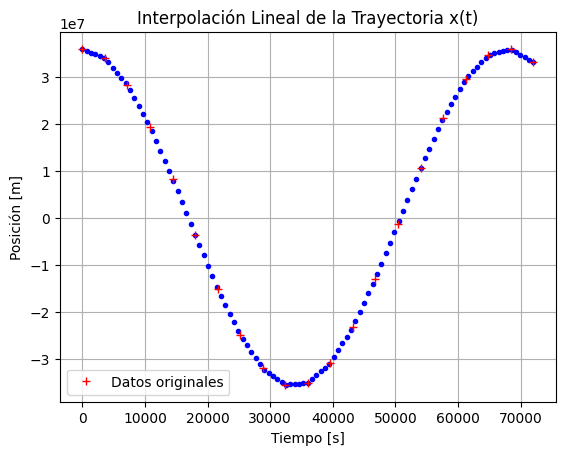

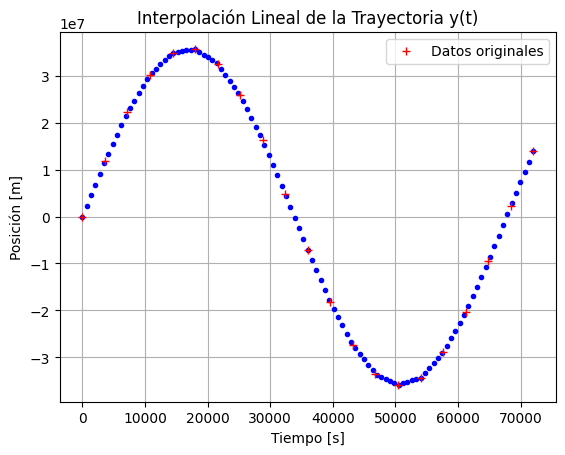

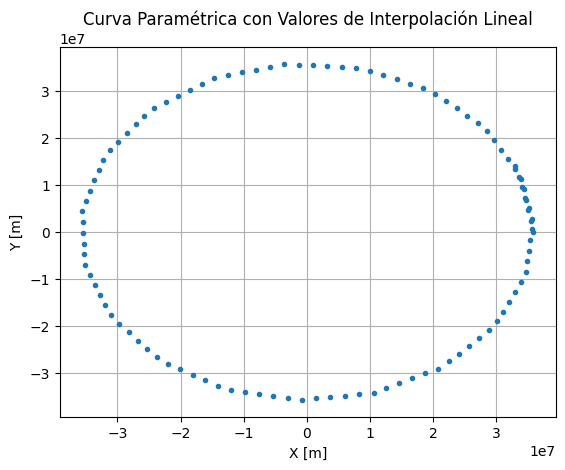

In [240]:
def get_data():
    data = np.loadtxt('./datos.txt')
    t = data[:, 0]
    x = data[:, 1]
    y = data[:, 2]
    return t, x, y



def graficar_interpolacion_lineal(ti,interpolation_points, title):
    x = np.linspace(ti[0], ti[-1], 5 * len(ti))
    F = interpolacion_lineal(ti,interpolation_points)
    values= [F(xi) for xi in x]
    plt.plot(x, values, '.', linewidth=1, color='blue')
    
    plt.plot(ti, interpolation_points, '+', color='red', label='Datos originales')
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Posición [m]")
    plt.title(f"Interpolación Lineal de la Trayectoria {title}")
    plt.legend()
    plt.grid()
    plt.show()
    return values
    

t, x, y = get_data()
xlin = graficar_interpolacion_lineal(ti=t, interpolation_points=x, title="x(t)")
ylin = graficar_interpolacion_lineal(ti=t, interpolation_points=y, title="y(t)")
plt.plot(xlin, ylin, '.', label="Trayectoria interpolada")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Curva Paramétrica con Valores de Interpolación Lineal")
plt.grid()
plt.show()

        

___
b. Utilizando las funciones interpoladas y un método para hallar raíces, encuentre el período $ T $ del satélite en unidades de horas.

Note que $y(t) = 0$ en 3 ocasiones, en la segunda ocasion la trayectoria lleva la mitad de su recorrido, en la tercera ocasion ha recorrido completamente la elipse.



In [241]:
def biseccion(a, b, f, e, Nmax):
    if f(a) * f(b) >= 0:
        print("El intervalo no contiene raices")
        return None
    for _ in range(Nmax):
        p = (b + a) / 2

        if np.abs(f(p)) < e: 
            return p
        if f(a) * f(p) < 0:
            b = p
        else:
            a = p
    print("Presición requerida no alcanzada")
    return p
        
Fy = interpolacion_lineal(t,y)
root_1 = 0
root_2 = biseccion(t[1],t[10],Fy, 1e-8, 1000 )
root_3 = biseccion(t[10],t[-1],Fy, 1e-8, 1000 )
print("root_1:", root_1, "Fy(root_1):", Fy(root_1))
print("root_2:", root_2, "Fy(root_2):", Fy(root_2))
print("root_3:", root_3, "Fy(root_3):", Fy(root_3))
print(f"El periodo es: {root_3}s ")



root_1: 0 Fy(root_1): 0.0
root_2: 33851.584455199794 Fy(root_2): 0.0
root_3: 67690.40829622939 Fy(root_3): 4.190951585769653e-09
El periodo es: 67690.40829622939s 


___

c. Calcule el error de la posición interpolada tras un periodo con $ \epsilon = |\vec{r}(T) - \vec{r}(0)| $



In [242]:

Fx = interpolacion_lineal(t,x)
Fy = interpolacion_lineal(t,y)
eps = np.abs((Fx(root_3) - Fx(root_1),Fy(root_3)- Fy(root_1)))

print(f"El error generado tras un periodo es: {eps}")



El error generado tras un periodo es: [3.15590352e+05 4.19095159e-09]


Note que el error es bastante grande para la componente en x
___

d. Dado que el error es grande, discuta brevemente cómo podría disminuirlo.

La interpolación lineal es uno de los metodos mas limitados y poco versatiles en todo el abanico de metodos numericos para interpolación, en este caso solo podria mejorarse la fidelidad de la interpolación a la función original añadiendo mas puntos de interpolación o en su defecto, usando algun metodo mas fidedigno, como Laggrange o Splines cubicos.
___
 

2) Utilizando la función $ f(x) = \sin(x) $ genere un conjunto datos de $ n $ puntos $ (x_n, f(x_n)) $ e interpole utilizando los métodos Lineal, Lagrange y Diferencias divididas. Teniendo en cuenta el resultado anterior, calcule el valor de error promedio $ \langle \epsilon \rangle $ para cada método como función de $ n $. Discuta los resultados con una gráfica donde solamente el eje vertical esté en escala logarítmica.


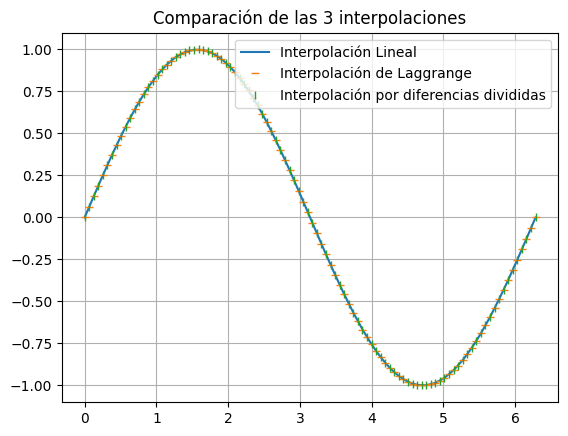

In [243]:
f = lambda x : np.sin(x)
def interpolations(n):

    x = np.linspace(0, 2*np.pi, n)

    interpolation_points = f(x)

    lineal_interpolation = interpolacion_lineal(x,interpolation_points)
    laggrange_interpolation = laggrange(x, interpolation_points)
    divided_difference = diferencia_dividida(x, interpolation_points)

    xi = np.linspace(0, 2*np.pi, 2*n)

    lineal_interpolation_values = [lineal_interpolation(x) for x in xi]
    laggrange_interpolation_values = [laggrange_interpolation(x) for x in xi]
    divided_difference_values = [divided_difference(x) for x in xi]
    return lineal_interpolation_values, laggrange_interpolation_values, divided_difference_values, xi 


lineal_interpolation_values, laggrange_interpolation_values, divided_difference_values, xi  = interpolations(50)

plt.plot(xi, lineal_interpolation_values, '-', label='Interpolación Lineal')
plt.plot(xi, laggrange_interpolation_values, '_', label='Interpolación de Laggrange')
plt.plot(xi, divided_difference_values , '|', label='Interpolación por diferencias divididas')
plt.title("Comparación de las 3 interpolaciones")
plt.legend()
plt.grid()






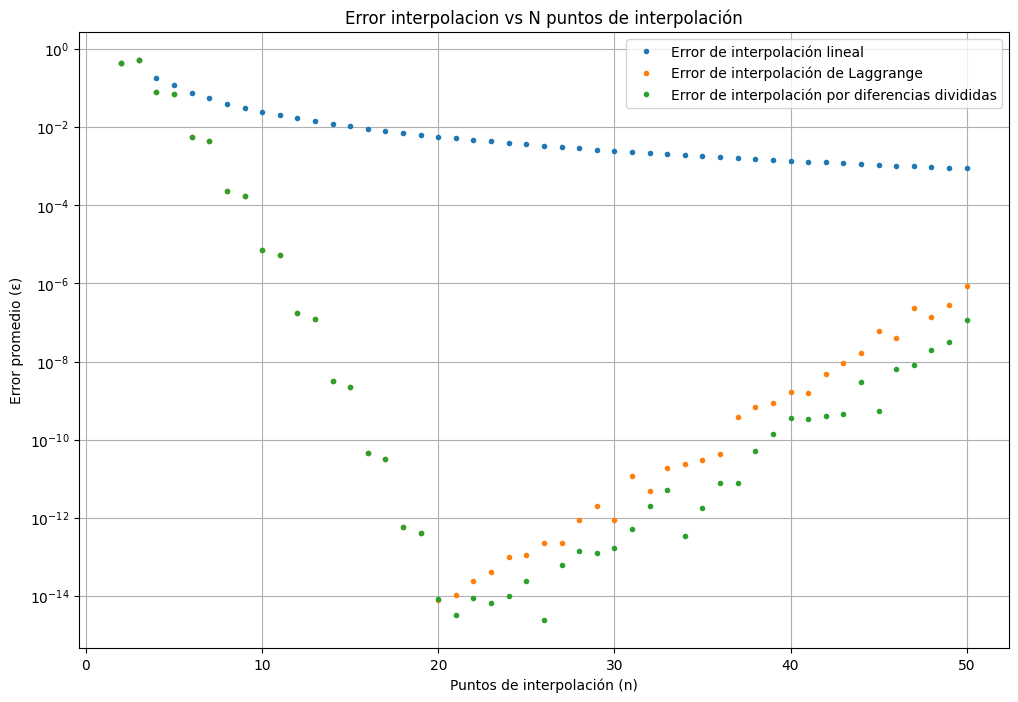

In [244]:
def average_error_interpolations(n):

    if(n < 2): return

    lineal_interpolation_values, laggrange_interpolation_values, divided_difference_values, xi  = interpolations(n)
    lineal_interpolation_error = np.abs(f(xi) - lineal_interpolation_values)
    laggrange_interpolation_error = np.abs(f(xi) - laggrange_interpolation_values)
    divided_difference_error = np.abs(f(xi) - divided_difference_values)
    lineal_interpolation_average_error = np.sum(lineal_interpolation_error) / len(xi)
    laggrange_interpolation_average_error = np.sum(laggrange_interpolation_error) / len(xi)
    divided_difference_average_error = np.sum(divided_difference_error)/ len(xi)
    # print(f"n = {n} \nError promedio de interpolación lineal: {lineal_interpolation_average_error} \nError promedio de interpolación de Laggrange: {laggrange_interpolation_average_error} \nError promedio de interpolación por diferencias divididas: {divided_difference_average_error}")
    return lineal_interpolation_average_error, laggrange_interpolation_average_error, divided_difference_average_error

lineal_errors = []
laggrange_errors = []
divided_difference_errors = []
n = np.arange(2, 51)

for _n in n:
    lineal_interpolation_average_error, laggrange_interpolation_average_error, divided_difference_average_error = average_error_interpolations(_n)
    lineal_errors.append(lineal_interpolation_average_error)
    laggrange_errors.append(laggrange_interpolation_average_error)
    divided_difference_errors.append(divided_difference_average_error)

plt.figure(figsize=(12, 8))
plt.plot(n, lineal_errors, '.', label="Error de interpolación lineal")
plt.plot(n, laggrange_errors, '.', label="Error de interpolación de Laggrange")
plt.plot(n, divided_difference_errors, '.', label="Error de interpolación por diferencias divididas")

plt.semilogy()
plt.grid()
plt.legend()
plt.title("Error interpolacion vs N puntos de interpolación")
plt.xlabel("Puntos de interpolación (n)")
plt.ylabel("Error promedio (ε)")
plt.show()

En el grafico anterior podemos ver caracteristicas muy importantes de los metodos de interpolación:
### Interpolación lineal:
- **Tendencia del error:** El error de la interpolación lineal disminuye de forma continua a medida que aumentamos los puntos de interpolación, lo que indica que esta interpolación se vuelve más precisa conforme se agrega más información.
- **Limitación en la velocidad de convergencia:** A pesar de esta mejora, la disminución del error es muy lenta en comparación con los otros métodos. Esto es una limitación intrínseca de la interpolación lineal, que no puede capturar la curvatura de funciones no lineales como sin⁡(x)sin(x) con gran precisión.
### Interpolación de Laggrange
- **Tendencia del errror:** Observamos una disminución significativa del error entre 2 y 20 puntos de interpolación, mostrando que la interpolación de Lagrange es muy precisa en ese rango para $sin⁡(x)$.
- **Cambio brusco del error después de 20 puntos:** A partir de aproximadamente 20 puntos, el error promedio comienza a aumentar rápidamente. Es probable que este comportamiento se le pueda atribuir a la generación de picos al añadir puntos de interpolación.
### Interpolación por diferencias divididas
- **Comportamiento similar al de Lagrange:** La interpolación por diferencias divididas es teóricamente equivalente a la interpolación de Lagrange, y como vimos anteriormente, muestra un comportamiento muy similar.
- **Leve ventaja en estabilidad:**  El error de diferencias divididas tiene un crecimiento levemente menor en comparación con Lagrange al superar los 20 puntos de interpolación para esta función. Esto puede deberse a la naturaleza de los calculo que implican diferencias divididas, tienden a tener menor error aritmetico debido a la naturaleza discreta de las computadoras.